In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [ ]:
num_states = 10
prob_next = 0.3
prob_prev = 0.3
prob_self = 1- (prob_next + prob_prev)
prob_edge = 0.2

In [ ]:
prob_matrix = np.zeros((num_states,3))

for i in range(num_states):
  if i == 0:
    prob_matrix[i][0] = 0
    prob_matrix[i][1] = prob_edge
    prob_matrix[i][2] = 1-prob_edge

  elif i == num_states-1:
    prob_matrix[i][0] = 1-prob_edge
    prob_matrix[i][1] = prob_edge
    prob_matrix[i][2] = 0

  else:
    prob_matrix[i][0] = prob_prev
    prob_matrix[i][1] = prob_self
    prob_matrix[i][2] = prob_next

In [ ]:
prob_matrix

array([[0. , 0.2, 0.8],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.3, 0.4, 0.3],
       [0.8, 0.2, 0. ]])

In [ ]:
Es=20
power_max=100
battery_max = 100
gain_max = 1.0
battery_factor = 0.3
discount_factor = 0.95

### Agent

In [ ]:
class Agent(): # actions of agent depends on policy, here we compute what happens after action
  def __init__(self):
    self.noise = 1.0
    self.gain_factor = 1 # power_max / num_states
    self.battery_prob = 0.5 # battery renew prob

  def channel_next_state(self,i):  # channel transition and it is independent of action

    prob = np.random.rand()

    if i == 1:
      # state 1,
      if prob > prob_edge: # retain same state, that is 1
        return 0
      else:
        return 1 # go to next state

    elif i == num_states: # next state from last state
      if prob > prob_edge:   # retain same state, that is last state
        return 0
      else:
        return -1 # go one state back

    else:
      if prob < prob_prev: # go to previous state
        return -1
      elif prob < prob_prev + prob_self: # retain the same state
        return 0
      else: # go to next state
        return 1

  def state_battery(self,battery,power_transmit): # battery remains and harvesting
  # transition of state: battery level
  # inputs are battery level and action tx power
    rand = np.random.rand()
    is_harvested = -1 # random initialization

    battery_spent = battery_factor * power_transmit # this is known if tx power is fixed

    if rand < self.battery_prob: # this is battery harvesting condition
      new_battery = np.minimum(power_max,battery + Es - battery_spent)
      new_battery = max(0,new_battery)
      is_harvested = 1

    else: # no battery harvesting
      new_battery = battery - battery_spent
      new_battery = max(0,new_battery)
      is_harvested = 0

    return new_battery, is_harvested

  def next_state_reward(self,init_state, transmit_energy):

    # initial state and action (tx power)
    transition = self.channel_next_state(init_state)  # transition ={-1,0,1}
    new_state = init_state + transition # new channel state after transition

    init_gain = (init_state ) * self.gain_factor # initial state => current state of channel
    new_gain = (new_state) * self.gain_factor # we dont need this

    snr = init_gain * transmit_energy / self.noise # snr based on current channel state

    reward = np.log(1 + snr) # this defines reward

    return new_state, reward

  def joint_state_reward_under_action(self,battery,power_transmit,init_state):

    new_battery, _ = self.state_battery(battery, power_transmit) # new battery state
    new_state, reward = self.next_state_reward(init_state, power_transmit) # new channel state and reward

    return new_state, reward, new_battery


agent = Agent()

In [ ]:
def get_discounted_rewards(rewards): # this function computes discounted cummulative reward
  d_reward = []
  d_reward.append(rewards[0])
  for i in range(1,len(rewards)):
    d_reward.append( pow(discount_factor,i) * rewards[i]  +  d_reward[i-1])

  return d_reward

### Value Iteration

In [ ]:
num_actions = 10

In [ ]:
def one_iteration():
    delta = 0

    for s in range(num_states):
        temp = value_function[s]
        v_list = np.zeros(num_actions)
        for a in range(num_actions):

            value_sum =  prob_matrix[s][0] * value_function[max(s -1,0)] + prob_matrix[s][1] * value_function[s] + prob_matrix[s][2] * value_function[min(s +1,9)]
            _, reward = agent.next_state_reward(s+1, (a+1)*10)
            v_list[a] = reward + discount_factor * value_sum

        value_function[s] = max(v_list)
        delta = max(delta, abs(temp - value_function[s]))

    return delta, value_function


def get_policy():
    pi = np.ones(num_states) * -1
    for s in range(num_states):
        v_list = np.zeros(num_actions)
        for a in range(num_actions):
            value_sum =  prob_matrix[s][0] * value_function[max(s - 1,0)] + prob_matrix[s][1] * value_function[s] + prob_matrix[s][2] * value_function[min(s + 1,9)]
            _, reward = agent.next_state_reward(s+1, (a+1)*10)
            v_list[a] = reward + discount_factor * value_sum

        max_index = []
        max_val = np.max(v_list)
        for a in range(num_actions):
            if v_list[a] == max_val:
                max_index.append(a)
        pi[s] = np.random.choice(max_index)
    return pi.astype(int)

def train( tol=1e-3):
    epoch = 0
    delta,values = one_iteration()
    delta_history = [delta]
    # value_history = []
    # value_history.append(np.array(values))
    while delta > tol:
        epoch += 1
        delta , values = one_iteration()
        delta_history.append(delta)
        # value_history.append(np.array(values))
        if delta < tol:
            break
    policy = get_policy()

    print(f'# iterations of policy improvement: {len(delta_history)}')
    print(f'delta = {delta_history}')

    return policy, delta_history

In [ ]:
# value_function = np.zeros(num_states)

# policy, delta_history, value_history = train()
# print(policy+1)

In [ ]:
# for i in range(10):
#   plt.plot(np.array(value_history)[:,i])
# plt.show()

In [ ]:
# plt.plot(delta_history)

### Value Iteration with battery

In [ ]:
num_actions = 10
battery_threshold = 30

In [ ]:
def one_iteration():
    delta = 0

    for channel in range(num_states):
      for battery in range(101):
          temp = value_function[channel][battery]
          v_list = np.zeros(num_actions)
          for a in range(num_actions):

              power_transmit = (a+1) * 10
              if battery < battery_threshold:
                reward = 0
                power_transmit = 0

              _, reward = agent.next_state_reward(channel+1, power_transmit)
              battery_spent = battery_factor * power_transmit

              new_battery_without_harvest = int(np.round(max(0, battery - battery_spent)))
              new_battery_with_harvest = int(np.round(np.minimum(power_max,battery + Es - battery_spent)))

              value_sum = 0
              for i,act in enumerate([-1,0,1]):
                  new_channel = np.clip(channel+act,0,9)
                  battery_prob_sum = (1-agent.battery_prob) * value_function[new_channel][new_battery_without_harvest]
                  battery_prob_sum +=  agent.battery_prob  *  value_function[new_channel][new_battery_with_harvest]

                  value_sum += prob_matrix[channel][i] * battery_prob_sum


              v_list[a] = reward + discount_factor * value_sum

          value_function[channel][battery] = max(v_list)
          delta = max(delta, abs(temp - value_function[channel][battery]))

    return delta, value_function


def get_policy():
    pi = np.ones((num_states,101)) * -1
    for channel in range(num_states):
      for battery in range(101):
        v_list = np.zeros(num_actions)
        for a in range(num_actions):
              power_transmit = (a+1) * 10
              if battery < battery_threshold:
                reward = 0
                power_transmit = 0

              _, reward = agent.next_state_reward(channel+1, power_transmit)
              battery_spent = battery_factor * power_transmit

              new_battery_without_harvest = int(np.round(max(0, battery - battery_spent)))
              new_battery_with_harvest = int(np.round(np.minimum(power_max,battery + Es - battery_spent)))

              value_sum = 0
              for i,act in enumerate([-1,0,1]):
                  new_channel = np.clip(channel+act,0,9)
                  battery_prob_sum = (1-agent.battery_prob) * value_function[new_channel][new_battery_without_harvest]
                  battery_prob_sum +=  agent.battery_prob  *  value_function[new_channel][new_battery_with_harvest]

                  value_sum += prob_matrix[channel][i] * battery_prob_sum


              v_list[a] = reward + discount_factor * value_sum

        max_index = []
        max_val = np.max(v_list)
        for a in range(num_actions):
            if v_list[a] == max_val:
                max_index.append(a)
        pi[channel][battery] = np.random.choice(max_index)
    return pi.astype(int)

def train( tol=1e-3):
    epoch = 0
    delta, values = one_iteration()
    delta_history = [delta]
    value_history = [np.array(values)]

    while delta > tol:
        epoch += 1
        delta, values = one_iteration()
        delta_history.append(delta)
        value_history.append(np.array(values))
        if delta < tol:
            break
        print(f"Iteration {epoch} : delta = {delta}")
    policy = get_policy()

    print(f'# iterations of policy improvement: {len(delta_history)}')
    print(f'delta = {delta_history}')

    return policy, delta_history, value_history

In [ ]:
value_function = np.zeros((num_states,101))

policy, delta_history, value_history = train()
print(policy+1)

Iteration 1 : delta = 15.679249237033048
Iteration 2 : delta = 10.523179144947179
Iteration 3 : delta = 8.917928313057935
Iteration 4 : delta = 7.7886663708344415
Iteration 5 : delta = 6.963443641295449
Iteration 6 : delta = 6.282206783609968
Iteration 7 : delta = 5.611806657993249
Iteration 8 : delta = 4.989479484842356
Iteration 9 : delta = 4.414825959306015
Iteration 10 : delta = 3.918835721995954
Iteration 11 : delta = 3.479545560076204
Iteration 12 : delta = 3.0894319179077243
Iteration 13 : delta = 2.748996744606437
Iteration 14 : delta = 2.504689808439167
Iteration 15 : delta = 2.2817968301542493
Iteration 16 : delta = 2.0770944914965312
Iteration 17 : delta = 1.8888459571515455
Iteration 18 : delta = 1.7162133221583176
Iteration 19 : delta = 1.558595525219701
Iteration 20 : delta = 1.4147800791963903
Iteration 21 : delta = 1.2835506703252477
Iteration 22 : delta = 1.1637451382121071
Iteration 23 : delta = 1.0544399336590828
Iteration 24 : delta = 0.9550215799948703
Iteration 25

In [ ]:
# with np.printoptions(threshold=np.inf):
#     print(policy+1)


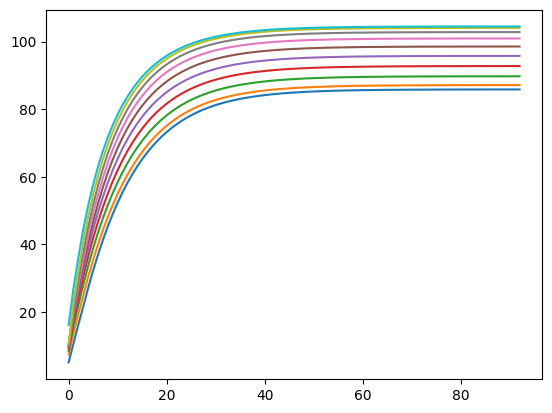

In [ ]:
value_func = np.array(value_history)

for i in range(10):
  plt.plot(value_func[:,i,40])

plt.show()

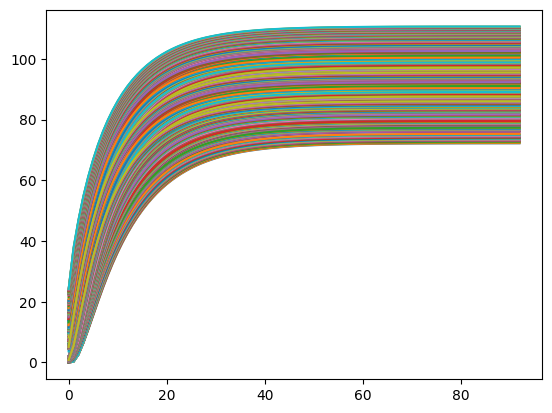

In [ ]:
for i in range(10):
  for j in range(101):
    plt.plot(value_func[:,i,j])

plt.show()

### Policy 3

In [ ]:
class Policy3():
  def __init__(self):
    pass

  def take_action(self,max_power,battery,init_state,battery_threshold):

    if(battery < battery_threshold):
       power_transmitted = 0
    else:
       power_transmitted = min(max_power, (num_states - init_state + 1) * 10)

    new_battery, is_harvested = agent.state_battery(battery, power_transmitted)

    if(new_battery < 0):
      power_transmitted = 0
      new_battery = 0

    new_state, reward = agent.next_state_reward(init_state, power_transmitted)

    return new_state, reward, new_battery, is_harvested, power_transmitted

In [ ]:
policy3 = Policy3()
battery = battery_max
time_steps = 1000
max_power = 100
init_state = 8
battery_threshold = 30
rewards = []



for i in range(time_steps):

  new_state, reward, new_battery, is_harvested, power_transmitted = policy3.take_action( max_power, battery, init_state, battery_threshold)
  battery = new_battery
  init_state = new_state

  # print(f"\n------------Time Step {i}-------------")
  # print(f"Energy Harvested {is_harvested}")
  # print(f"power transmited {power_transmitted}")
  # print(f"Remaining Battery {new_battery}",)
  # print(f"Gain {new_state/10}")
  # print(f"Reward {reward}")
  # print("---------------------------------\n")

  if new_battery < 0:
      print("You've used all your battery")
      break

  rewards.append(reward)

discounted_rewards_3 = get_discounted_rewards(rewards)


In [ ]:
print(f"Outage observed in {rewards.count(0.0)} out of {time_steps} transmissions")
print(f"Average reward: {np.array(rewards).mean()}")
print(f"Total reward: {np.array(rewards).sum()}")
print(f"Cummulative reward: {discounted_rewards_3[-1]}")

Outage observed in 180 out of 1000 transmissions
Average reward: 4.249439932927679
Total reward: 4249.4399329276785
Cummulative reward: 98.20806003055883


In [ ]:
# # discounted_rewards_1
# plt.plot(discounted_rewards_1,label="Policy1")

# plt.plot(discounted_rewards_2,label="Policy2")
# plt.plot(discounted_rewards_2_1,label="Policy2_1")

# plt.plot(discounted_rewards_3,label="Policy3")
# plt.legend()
# plt.show()